In [ ]:
# Transformers installation
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Token classification

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset
from datasets import Dataset, Features, ClassLabel, Sequence, Value

def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  if l[1].strip() == 'c':
                    label.append(1)
                  else:
                    label.append(0)

      if len(sentence) >0:
                  print("printing data value:", sentence, label)
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      
      return {'tokens': sentences, 'ner_tags': labels}


training_data_dict = process_data("train.tsv")
testing_data_dict = process_data("dev.tsv")
testing_data_dict_1 = process_data("test.tsv")
data_realec = process_data("en_realec_dev")
features = Features({'tokens': Sequence(feature=Value(dtype='string', id=None)), 'ner_tags': Sequence(feature=ClassLabel(names=['i', 'c'], id=None), length=-1, id=None)})

my_dataset = Dataset.from_dict({
    'tokens': training_data_dict['tokens'],
    'ner_tags': training_data_dict['ner_tags']
}, features=features)

test_dataset = Dataset.from_dict({
    'tokens': testing_data_dict['tokens'],
    'ner_tags': testing_data_dict['ner_tags']
}, features=features)

test_dataset_1 = Dataset.from_dict({
    'tokens': testing_data_dict_1['tokens'],
    'ner_tags': testing_data_dict_1['ner_tags']
}, features=features)

test_dataset_realec = Dataset.from_dict({
    'tokens': testing_data_dict_1['tokens'],
    'ner_tags': testing_data_dict_1['ner_tags']
}, features=features)


print("first training example:", my_dataset["tokens"][0])

first training example: ['Dear', 'Sir', 'or', 'Madam', ',']


Then take a look at an example:

In [ ]:
label_list = my_dataset.features[f"ner_tags"].feature.names
label_list

['i', 'c']

## Preprocess

In [ ]:
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer, OpenAIGPTModel



tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
# example = wnut["train"][0]
example = my_dataset["tokens"][0]
print("example:", example)
tokenized_input = tokenizer(example, is_split_into_words=True)
print(tokenized_input)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

label_all_tokens = False

example: ['Dear', 'Sir', 'or', 'Madam', ',']
{'input_ids': [101, 6203, 2909, 2030, 21658, 1010, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'dear', 'sir', 'or', 'madam', ',', '[SEP]']


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"],is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_train_data = my_dataset.map(tokenize_and_align_labels, batched=True)

tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data_1 = test_dataset_1.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/28731 [00:00<?, ? examples/s]

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_test_data_1[0])
print(tokenized_test_data_1['labels'][0])

{'tokens': ['Dear', 'Mrs', 'Smith'], 'ner_tags': [1, 1, 1], 'input_ids': [101, 6203, 3680, 3044, 102], 'attention_mask': [1, 1, 1, 1, 1], 'labels': [-100, 1, 1, 1, -100]}
[-100, 1, 1, 1, -100]


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


## Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [ ]:
id2label = {
    0: "i",
    1: "c"
}
label2id = {
    "i": 0,
    "c": 1
}

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
training_args = TrainingArguments(
    output_dir="distilbert-token-class",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None,
)

trainer.train()

Cloning https://huggingface.co/Varunreddy/distilbert-token-class into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.5k/253M [00:00<?, ?B/s]

Download file runs/May16_23-16-42_ee3256d586d0/1684279004.93231/events.out.tfevents.1684279004.ee3256d586d0.73…

Download file runs/May16_22-32-36_ee3256d586d0/1684276369.3878963/events.out.tfevents.1684276369.ee3256d586d0.…

Download file runs/May17_05-04-35_a1789c6a292c/events.out.tfevents.1684299877.a1789c6a292c.1435.0: 100%|######…

Download file runs/May16_22-42-55_ee3256d586d0/1684276978.2341146/events.out.tfevents.1684276978.ee3256d586d0.…

Download file runs/May17_03-43-49_a9f42190e131/1684295032.2959015/events.out.tfevents.1684295032.a9f42190e131.…

Download file runs/May16_23-29-14_ee3256d586d0/events.out.tfevents.1684279759.ee3256d586d0.22972.0: 100%|#####…

Clean file runs/May16_23-16-42_ee3256d586d0/1684279004.93231/events.out.tfevents.1684279004.ee3256d586d0.7348.…

Clean file runs/May16_22-32-36_ee3256d586d0/1684276369.3878963/events.out.tfevents.1684276369.ee3256d586d0.734…

Clean file runs/May17_05-04-35_a1789c6a292c/events.out.tfevents.1684299877.a1789c6a292c.1435.0:  17%|#7       …

Clean file runs/May16_22-42-55_ee3256d586d0/1684276978.2341146/events.out.tfevents.1684276978.ee3256d586d0.734…

Clean file runs/May17_03-43-49_a9f42190e131/1684295032.2959015/events.out.tfevents.1684295032.a9f42190e131.204…

Clean file runs/May16_23-29-14_ee3256d586d0/events.out.tfevents.1684279759.ee3256d586d0.22972.0:  16%|#5      …

Download file runs/May17_05-04-35_a1789c6a292c/1684299877.6990979/events.out.tfevents.1684299877.a1789c6a292c.…

Clean file runs/May17_05-04-35_a1789c6a292c/1684299877.6990979/events.out.tfevents.1684299877.a1789c6a292c.143…

Download file runs/May17_02-56-50_a9f42190e131/1684292288.2127001/events.out.tfevents.1684292288.a9f42190e131.…

Clean file runs/May17_02-56-50_a9f42190e131/1684292288.2127001/events.out.tfevents.1684292288.a9f42190e131.204…

Download file runs/May16_23-29-14_ee3256d586d0/1684279759.704096/events.out.tfevents.1684279759.ee3256d586d0.2…

Download file runs/May16_22-43-42_ee3256d586d0/1684277024.5299027/events.out.tfevents.1684277024.ee3256d586d0.…

Clean file runs/May16_23-29-14_ee3256d586d0/1684279759.704096/events.out.tfevents.1684279759.ee3256d586d0.2297…

Download file runs/May16_23-53-46_ee3256d586d0/1684281229.2398572/events.out.tfevents.1684281229.ee3256d586d0.…

Clean file runs/May16_22-43-42_ee3256d586d0/1684277024.5299027/events.out.tfevents.1684277024.ee3256d586d0.734…

Download file runs/May16_23-25-49_ee3256d586d0/1684279551.5774868/events.out.tfevents.1684279551.ee3256d586d0.…

Clean file runs/May16_23-53-46_ee3256d586d0/1684281229.2398572/events.out.tfevents.1684281229.ee3256d586d0.229…

Download file runs/May17_03-43-49_a9f42190e131/events.out.tfevents.1684295032.a9f42190e131.2041.2: 100%|######…

Clean file runs/May16_23-25-49_ee3256d586d0/1684279551.5774868/events.out.tfevents.1684279551.ee3256d586d0.734…

Clean file runs/May17_03-43-49_a9f42190e131/events.out.tfevents.1684295032.a9f42190e131.2041.2:  19%|#8       …

Download file runs/May16_23-53-46_ee3256d586d0/events.out.tfevents.1684281229.ee3256d586d0.22972.2: 100%|#####…

Clean file runs/May16_23-53-46_ee3256d586d0/events.out.tfevents.1684281229.ee3256d586d0.22972.2:  21%|##      …

Download file runs/May17_02-56-50_a9f42190e131/events.out.tfevents.1684292288.a9f42190e131.2041.0: 100%|######…

Download file runs/May16_23-25-49_ee3256d586d0/events.out.tfevents.1684279551.ee3256d586d0.7348.8: 100%|######…

Clean file runs/May17_02-56-50_a9f42190e131/events.out.tfevents.1684292288.a9f42190e131.2041.0:  21%|##1      …

Download file runs/May16_22-43-42_ee3256d586d0/events.out.tfevents.1684277024.ee3256d586d0.7348.4: 100%|######…

Clean file runs/May16_23-25-49_ee3256d586d0/events.out.tfevents.1684279551.ee3256d586d0.7348.8:  26%|##5      …

Clean file runs/May16_22-43-42_ee3256d586d0/events.out.tfevents.1684277024.ee3256d586d0.7348.4:  25%|##5      …

Download file runs/May16_22-32-36_ee3256d586d0/events.out.tfevents.1684276369.ee3256d586d0.7348.0: 100%|######…

Clean file runs/May16_22-32-36_ee3256d586d0/events.out.tfevents.1684276369.ee3256d586d0.7348.0:  26%|##5      …

Download file runs/May16_23-16-42_ee3256d586d0/events.out.tfevents.1684279004.ee3256d586d0.7348.6: 100%|######…

Download file runs/May16_22-42-55_ee3256d586d0/events.out.tfevents.1684276978.ee3256d586d0.7348.2: 100%|######…

Clean file runs/May16_23-16-42_ee3256d586d0/events.out.tfevents.1684279004.ee3256d586d0.7348.6:  26%|##5      …

Clean file runs/May16_22-42-55_ee3256d586d0/events.out.tfevents.1684276978.ee3256d586d0.7348.2:  26%|##5      …

Download file training_args.bin: 100%|##########| 3.81k/3.81k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##6       | 1.00k/3.81k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/253M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.318500,0.292038


TrainOutput(global_step=898, training_loss=0.3058951787799929, metrics={'train_runtime': 160.1332, 'train_samples_per_second': 179.419, 'train_steps_per_second': 5.608, 'total_flos': 359227891537788.0, 'train_loss': 0.3058951787799929, 'epoch': 1.0})

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()
# trainer.save_model("/")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/253M [00:00<?, ?B/s]

Upload file runs/May17_17-56-39_1b18c8ee29fb/events.out.tfevents.1684346276.1b18c8ee29fb.7115.0:   0%|        …

To https://huggingface.co/Varunreddy/distilbert-token-class
   bd9780a..55e4808  main -> main

   bd9780a..55e4808  main -> main

To https://huggingface.co/Varunreddy/distilbert-token-class
   55e4808..396a4f6  main -> main

   55e4808..396a4f6  main -> main



'https://huggingface.co/Varunreddy/distilbert-token-class/commit/55e4808cdc1fade4c46697f6a2f045a10a212f92'

In [ ]:
text = "I saws an eye."

In [ ]:
from transformers import pipeline

classifier = pipeline("ner", model="Varunreddy/distilbert-token-class")
classifier(text)

[{'entity': 'c',
  'score': 0.94224757,
  'index': 1,
  'word': 'i',
  'start': 0,
  'end': 1},
 {'entity': 'i',
  'score': 0.8220675,
  'index': 2,
  'word': 'saw',
  'start': 2,
  'end': 5},
 {'entity': 'i',
  'score': 0.7503559,
  'index': 3,
  'word': '##s',
  'start': 5,
  'end': 6},
 {'entity': 'c',
  'score': 0.56439763,
  'index': 4,
  'word': 'an',
  'start': 7,
  'end': 9},
 {'entity': 'c',
  'score': 0.77317667,
  'index': 5,
  'word': 'eye',
  'start': 10,
  'end': 13},
 {'entity': 'c',
  'score': 0.9681921,
  'index': 6,
  'word': '.',
  'start': 13,
  'end': 14}]

In [ ]:
import numpy as np

predictions, labels, _ = trainer.predict(tokenized_test_data_1)
predictions = np.argmax(predictions, axis=2)

print(predictions[1], labels[1])
eval_labels = []
eval_preds = []
for i in range(len(labels)):
   eval_labels.extend(labels[i])
   eval_preds.extend(predictions[i])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [-100    1    1    1    1    1    1    1    1    1    0    0    0    0
    0    0    0    0    1 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100]


In [ ]:
new_labels = []
new_predictions = []
for i in range(len(eval_labels)):
    if(eval_labels[i]!=-100):
      new_labels.append(eval_labels[i])
      new_predictions.append(eval_preds[i])

print(len(new_labels))
print(len(new_predictions))


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

results = accuracy_score(new_labels, new_predictions)
print("accuracy: ", results)
print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
print( "F0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

41477
41477
accuracy:  0.8737854714661137
precision:  0.8242107147796087
recall:  0.6146628107770464
F0.5 score: 0.7174355631355568


In [ ]:
loss_history = trainer.state.log_history

print(loss_history)
train_loss_values = []
train_loss_epochs = []
eval_loss_values = []
eval_loss_epochs = []

for log in loss_history:
  if "loss" in log:
    train_loss_values.append(log["loss"])
    train_loss_epochs.append(log["epoch"])
  if "train_loss" in log:
    train_loss_values.append(log["train_loss"])
    train_loss_epochs.append(log["epoch"])
  if "eval_loss" in log:
    eval_loss_values.append(log["eval_loss"])
    eval_loss_epochs.append(log["epoch"])

train_loss_values

[{'loss': 0.3185, 'learning_rate': 4.432071269487751e-06, 'epoch': 0.56, 'step': 500}, {'eval_loss': 0.29203757643699646, 'eval_runtime': 3.2641, 'eval_samples_per_second': 680.741, 'eval_steps_per_second': 21.445, 'epoch': 1.0, 'step': 898}, {'train_runtime': 160.1332, 'train_samples_per_second': 179.419, 'train_steps_per_second': 5.608, 'total_flos': 359227891537788.0, 'train_loss': 0.3058951787799929, 'epoch': 1.0, 'step': 898}]


[0.3185, 0.3058951787799929]

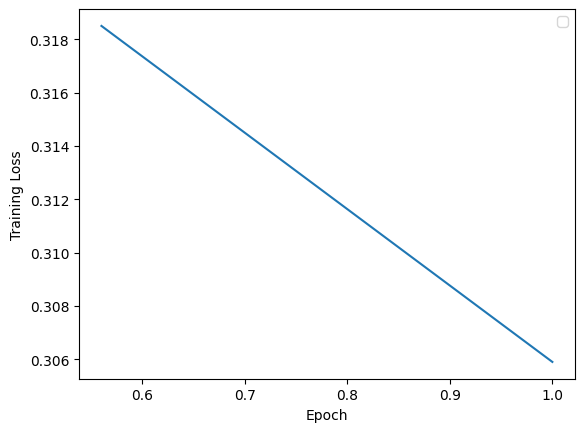

In [ ]:
# Plotting Training Loss Curve

import matplotlib.pyplot as plt
plt.plot(train_loss_epochs, train_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

[0.29203757643699646]


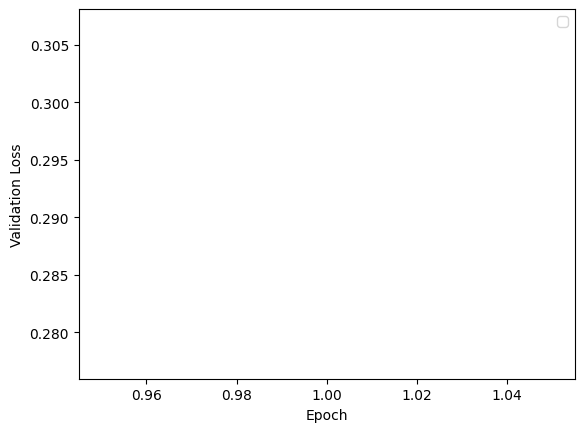

In [ ]:
# Plotting Validation Loss Curve

import matplotlib.pyplot as plt
print(eval_loss_values)
plt.plot(eval_loss_epochs, eval_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [ ]:
#Error Analysis

tokens = []
true_labels = []
pred_labels = []

for i in range(len(labels)):
    temp_labels = []
    temp_preds = []
    flag = False
    for w in zip(labels[i], predictions[i]):
        if(w[0]!=-100):
            if(w[0]!=w[1]):
               flag = True
            temp_labels.append(id2label[w[0]])
            temp_preds.append(id2label[w[1]])
    if(flag):
        true_labels.append(temp_labels)
        pred_labels.append(temp_preds)
        tokens.append(tokenized_test_data_1['tokens'][i])
  
print(true_labels[0], pred_labels[0], tokens[0])

['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'c'] ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c'] ['I', 'have', 'received', 'your', 'letter', ',', 'which', 'was', 'about', 'that', 'you', 'would', 'like', 'me', 'to', 'inform', 'you', '.']


In [ ]:
import csv

label_file = "error_sentences2.tsv"
with open(label_file, 'w', encoding='utf8', newline='') as tsv_file:
        tsv_writer = csv.writer(tsv_file, delimiter='\t', lineterminator='\n')
        tsv_writer.writerow(["Token", "True Label","Predicted Label"])
        for index in range(140):
            sentenceList = tokens[index]
            labelList = true_labels[index]
            predictionList = pred_labels[index]
            for i in range(len(sentenceList)):
                tsv_writer.writerow([sentenceList[i], labelList[i],predictionList[i]])
            tsv_writer.writerow('')
                    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = [num for sublist in true_labels[:201] for num in sublist]
predictions = [num for sublist in pred_labels[:201] for num in sublist]

from sklearn.metrics import classification_report

target_names = ['c','i']

print("Test data report:")
print(classification_report(labels, predictions, target_names=target_names))

Test data report:
              precision    recall  f1-score   support

           c       0.81      0.97      0.89      2658
           i       0.81      0.34      0.48       901

    accuracy                           0.81      3559
   macro avg       0.81      0.66      0.68      3559
weighted avg       0.81      0.81      0.78      3559



In [ ]:
with open('Error-Sentences-analysis.txt', 'w') as f:
    for line in tokens[:100]:
        f.write(" ".join(line))
        f.write('\n')

In [ ]:
with open('analysis-file-final.txt', 'w') as f:
    for i in range(100):
        new_list = []
        for j in range(len(tokens[i])):
            if(true_labels[i][j]!=pred_labels[i][j]):
                new_list.append(tokens[i][j]+"#")
            else:
                new_list.append(tokens[i][j])
        f.write(" ".join(new_list))
        f.write('\n')

In [ ]:
# REALEC 

